### SAT-2906 - Historical distribution of BW increase

follow up from slides showing Tipping point analysis in Fiber Funnel section.

- When people upgrade, what’s the distribution of their BW increase? History of when people upgrade at all, not just to 1 Mbps. 
- If we compare the distributions of people upgrading to those that need to upgrade and they are less overall, that would be compelling.

Needed for insights 3 Tuesday.

In [1]:
from __future__ import division
from collections import defaultdict

import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#query data
def getData(conn, filename):

    cur = conn.cursor()
    cur.execute(open(filename, "r").read())
    names = [x[0] for x in cur.description]
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=names)

#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)



#pull bandwidths from DB
df = getData(myConnection, 'bw_increase.sql')

In [4]:
df.head()

,district_id,funding_year,in_universe,district_type,state_code,locale,size,num_students,fit_for_ia,fit_for_ia_cost,ia_bw_mbps_total,upgrade_indicator,meeting_2014_goal_no_oversub,meeting_2018_goal_oversub
0,881421,2015,True,Traditional,AL,Rural,Large,5598,True,True,800,False,True,False
1,881421,2016,True,Traditional,AL,Rural,Medium,5498,True,True,750,False,True,False
2,881421,2017,True,Traditional,AL,Rural,Medium,5523,True,True,1500,True,True,False
3,881421,2018,True,Traditional,AL,Rural,Medium,5540,True,True,1500,False,True,False
4,881421,2019,True,Traditional,AL,Rural,Medium,5687,True,True,2000,True,True,False


### Convert Decimals to Floats

In [5]:
numeric_cols = ['num_students', 'ia_bw_mbps_total']
df[numeric_cols] = df[numeric_cols].astype(float)

### Masks/Filters

In [6]:
# usual filters
mask_traditional = df.district_type == 'Traditional'
mask_fit_ia = df.fit_for_ia == True
mask_fit_cost = df.fit_for_ia_cost == True
mask_in_universe = df.in_universe == True

# meeting goal filters
mask_not_meeting = df.meeting_2018_goal_oversub == False
mask_meeting = df.meeting_2018_goal_oversub == True

# upgrade indicators
upgrade_2016 = (df.funding_year == 2016) & (df.upgrade_indicator == True)
upgrade_2017 = (df.funding_year == 2017) & (df.upgrade_indicator == True)
upgrade_2018 = (df.funding_year == 2018) & (df.upgrade_indicator == True)
upgrade_2019 = (df.funding_year == 2019) & (df.upgrade_indicator == True)

### Plotting the Bandwidth Increases

In [7]:
teals = ['#bfe6ef', '#6acce0', '#009296', '#004f51']
oranges = ['#fac4a5', '#f26c23', '#c44f27', '#83351a']

### All Districts, Percent Axis 

In [77]:
# create resultant dictionary
df_result_all = defaultdict()

for fy_prev, upgrade_year in zip([2015, 2016, 2017, 2018], [upgrade_2016, upgrade_2017, upgrade_2018, upgrade_2019]):
    # upgrade indicator true for specific year
    # get district_ids
    df_temp = df[mask_traditional & 
                 mask_fit_ia & 
                 mask_in_universe & 
                 upgrade_year ]
    d_id_upgraders = df_temp.district_id.unique()

    # get the previous year and funding_year and `ia_bw_mbps_total`
    df_temp_prev = df[mask_traditional & mask_fit_ia & mask_in_universe & 
       (df.funding_year == fy_prev) & 
       df.district_id.isin(d_id_upgraders)][['district_id', 'ia_bw_mbps_total']]

    # rename `ia_bw_mbps_total_previous`
    df_temp_prev.columns = ['district_id', 'ia_bw_mbps_total_previous']

    # set index to district_id
    df_temp.set_index('district_id', inplace=True)
    df_temp_prev.set_index('district_id', inplace=True)

    # concat this as a new column to the original dataframe
    df_result_all[str(fy_prev+1)] = pd.concat([df_temp, df_temp_prev], axis=1, join='inner')
    
    # take the difference of `ia_bw_mbps_total` in 2019 and the year before 2018 
    # and call this new column `bw_increase`
    df_result_all[str(fy_prev+1)].loc[:, 'bw_increase'] = df_result_all[str(fy_prev+1)]['ia_bw_mbps_total'] - df_result_all[str(fy_prev+1)]['ia_bw_mbps_total_previous']

    # reset index
    df_result_all[str(fy_prev+1)].reset_index(inplace=True)


In [78]:
# combine all dataframes into one 
df_result_all_combined = pd.concat([df_result_all['2016'], df_result_all['2017'], df_result_all['2018'], df_result_all['2019']])

# add 'bw_pct_change'
df_result_all_combined.loc[:, 'bw_pct_change'] = ((df_result_all_combined.loc[:, 'ia_bw_mbps_total'] - df_result_all_combined.loc[:, 'ia_bw_mbps_total_previous'])/df_result_all_combined.loc[:, 'ia_bw_mbps_total_previous'])*100


### Plotting the distribution

In [62]:
# indicate bins for categories
max_bin = 1050
increment = 50
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_result_all_combined['bw_pct_change_category'] = pd.cut(df_result_all_combined['bw_pct_change'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_result_all_combined['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_result_all_combined[['bw_pct_change_category']] = df_result_all_combined[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_result_all_combined['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].astype(str)['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].astype(str)

In [63]:
# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_result_all_combined.bw_pct_change_category.value_counts().to_frame()

In [64]:
# merge into resultant dataframe
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count']

# add percentage column
df_pct_change['pct_by_category'] = df_pct_change['district_count']/df_pct_change['district_count'].sum()

### Plotting by Bw Increase Percentage

In [65]:
df_pct_change

,pct_category,district_count,pct_by_category
0,less than 50%,1859,0.129079
1,50%,1802,0.125122
2,100%,3807,0.264338
3,150%,1311,0.091029
4,200%,1034,0.071796
5,250%,164,0.011387
6,300%,686,0.047632
7,350%,100,0.006943
8,400%,1165,0.080892
9,450%,67,0.004652


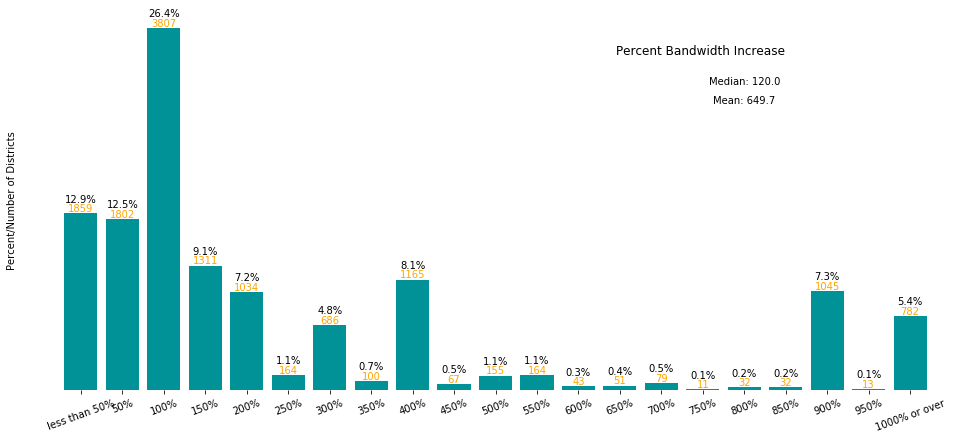

In [68]:
# plotting the figure
plt.figure(figsize=(17, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['district_count'], color='#009296')

# ticks, titles, axis labels
plt.ylabel("Percent/Number of Districts")
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                                    df_pct_change['district_count'], 
                                    df_pct_change['district_count'],
                                    df_pct_change['pct_by_category']
                                   ):
    plt.text(x0, v0, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+ 100, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(15, 3500, "Percent Bandwidth Increase ", ha='center', va='bottom', fontsize=12)
plt.text(16, 3200, "Median: "+str(df_result_all_combined.bw_pct_change.median()), ha='center', va='bottom')
plt.text(16, 3000, "Mean: "+str(round(df_result_all_combined.bw_pct_change.mean(), 1)), ha='center', va='bottom');
    
# save
plt.savefig("pct_bw_increase_whiteboard_fup_072519.png", bbox_inches = 'tight')

### Plot Beyond 1000%

In [79]:
# indicate bins for categories
max_bin = 6100
increment = 100
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_result_all_combined['bw_pct_change_category'] = pd.cut(df_result_all_combined['bw_pct_change'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_result_all_combined['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_result_all_combined[['bw_pct_change_category']] = df_result_all_combined[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_result_all_combined['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].astype(str)['bw_pct_change_category'] = df_result_all_combined['bw_pct_change_category'].astype(str)

# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_result_all_combined.bw_pct_change_category.value_counts().to_frame()


# merge into resultant dataframe
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count']

# add percentage column
df_pct_change['pct_by_category'] = df_pct_change['district_count']/df_pct_change['district_count'].sum()

In [80]:
df_pct_change

,pct_category,district_count,pct_by_category
0,less than 100%,3661,0.254201
1,100%,5118,0.355367
2,200%,1198,0.083183
3,300%,786,0.054576
4,400%,1232,0.085544
5,500%,319,0.022150
6,600%,94,0.006527
7,700%,90,0.006249
8,800%,64,0.004444
9,900%,1058,0.073462


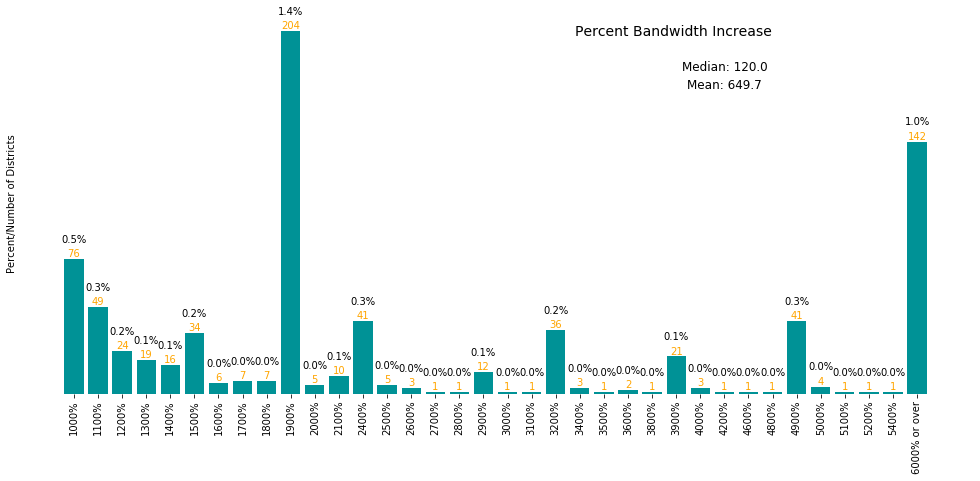

In [81]:
# plotting the figure
plt.figure(figsize=(17, 7))
xmarks = np.arange(0, df_pct_change.loc[10:, :].shape[0])
plt.bar(xmarks, df_pct_change.loc[10:, :]['district_count'], color='#009296')

# ticks, titles, axis labels
plt.ylabel("Percent/Number of Districts")
plt.xticks(xmarks, df_pct_change.loc[10:, :].pct_category.values, rotation=90)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                                    df_pct_change.loc[10:, :]['district_count'], 
                                    df_pct_change.loc[10:, :]['district_count'],
                                    df_pct_change.loc[10:, :]['pct_by_category']
                                   ):
    plt.text(x0, v0, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+8, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(25, 200, "Percent Bandwidth Increase ", ha='center', va='bottom', fontsize=14)
plt.text(27, 180, "Median: "+str(df_result_all_combined.bw_pct_change.median()), ha='center', va='bottom', fontsize=12)
plt.text(27, 170, "Mean: "+str(round(df_result_all_combined.bw_pct_change.mean(), 1)), ha='center', va='bottom', fontsize=12);
    
# save
#plt.savefig("pct_bw_increase_whiteboard_fup_1000andmore_072419.png", bbox_inches = 'tight')

In [20]:
# converting to a .py file
# !jupyter nbconvert --to script historical_bw_increase.ipynb

In [72]:
df_result_all_combined.columns

Index(['district_id', 'funding_year', 'in_universe', 'district_type',
       'state_code', 'locale', 'size', 'num_students', 'fit_for_ia',
       'fit_for_ia_cost', 'ia_bw_mbps_total', 'upgrade_indicator',
       'meeting_2014_goal_no_oversub', 'meeting_2018_goal_oversub',
       'ia_bw_mbps_total_previous', 'bw_increase', 'bw_pct_change',
       'bw_pct_change_category'],
      dtype='object')

In [82]:
sub_cols = ['district_id', 'funding_year','fit_for_ia','state_code','size','locale','num_students','ia_bw_mbps_total', 'ia_bw_mbps_total_previous', 'bw_increase', 'bw_pct_change']
df_142 = df_result_all_combined[sub_cols][df_result_all_combined.bw_pct_change_category == '6000% or over']

In [83]:
df_142

,district_id,funding_year,fit_for_ia,state_code,size,locale,num_students,ia_bw_mbps_total,ia_bw_mbps_total_previous,bw_increase,bw_pct_change
151,882198,2016,True,AR,Small,Town,2437.0,1000.0,7.500,992.500,1.323333e+04
174,882311,2016,True,CO,Small,Rural,1005.0,100.0,1.540,98.460,6.393506e+03
243,882639,2016,True,CA,Small,Suburban,2103.0,10000.0,10.000,9990.000,9.990000e+04
287,882862,2016,True,CA,Small,Urban,1042.0,10000.0,10.000,9990.000,9.990000e+04
291,882922,2016,True,CA,Large,Urban,15544.0,5000.0,1.500,4998.500,3.332333e+05
309,883067,2016,True,CA,Tiny,Rural,70.0,1000.0,5.000,995.000,1.990000e+04
359,883275,2016,True,CA,Tiny,Rural,16.0,1001.5,1.500,1000.000,6.666667e+04
413,883655,2016,True,CA,Small,Suburban,1458.0,1250.0,10.000,1240.000,1.240000e+04
419,883701,2016,True,CA,Small,Rural,1101.0,100.0,1.500,98.500,6.566667e+03
427,883786,2016,True,CA,Tiny,Town,35.0,100.0,1.500,98.500,6.566667e+03


In [59]:
# save df_142 - table of districts at 6000% or more
df_142.to_csv('districts_pct_bw_increase_6000andmore_072419.csv', index=False)

In [90]:
df_142[df_142.district_id == 969835]

,district_id,funding_year,fit_for_ia,state_code,size,locale,num_students,ia_bw_mbps_total,ia_bw_mbps_total_previous,bw_increase,bw_pct_change
3139,969835,2017,True,TX,Tiny,Rural,104.0,100.0,1.5,98.5,6566.666667
3421,969835,2018,True,TX,Tiny,Rural,112.0,10000.0,100.0,9900.0,9900.000000


In [84]:
# 969835 shows up twice, which is a Tiny, Rural district in TX
df_142.district_id.nunique()

141

In [70]:
df_142.funding_year.value_counts()

2016    48
2017    36
2018    34
2019    24
Name: funding_year, dtype: int64

In [85]:
df_142['size'].value_counts()

Small     63
Tiny      62
Medium    14
Large      2
Mega       1
Name: size, dtype: int64

In [93]:
# percent of the 142 that are Small/Tiny
(df_142['size'].value_counts()['Small'] + df_142['size'].value_counts()['Tiny'] - 1)/df_142.district_id.nunique()

0.8794326241134752

In [94]:
df_142['locale'].value_counts()

Rural       102
Suburban     21
Town         13
Urban         6
Name: locale, dtype: int64

In [96]:
# percent of the 142 that are Rural/Town
(df_142['locale'].value_counts()['Rural'] + df_142['locale'].value_counts()['Town'] - 1)/df_142.district_id.nunique()




0.8085106382978723

### Previous year bandwidth

In [97]:
# median ia_bw_mbps_total_previous
df_142.ia_bw_mbps_total_previous.median()

10.0

In [98]:
# mean ia_bw_mbps_total_previous
df_142.ia_bw_mbps_total_previous.mean()

43.213802816901406

### Bandwidth upgraded to (the current ia_bw_mbps_total)

In [100]:
# median ia_bw_mbps_total
df_142.ia_bw_mbps_total.median()

1000.0

In [102]:
# mean ia_bw_mbps_total
df_142.ia_bw_mbps_total.max()

1551000.0

In [105]:
# removing one outlier at 1551000.0
len(df_142.ia_bw_mbps_total.values)

142

In [120]:
print(f"Median 'ia_bw_mbps_total' (removing outlier 1551000 Mbps): {df_142.sort_values('ia_bw_mbps_total')['ia_bw_mbps_total'].median()}")
      
print(f"Mean 'ia_bw_mbps_total' (removing outlier 1551000 Mbps): {df_142.sort_values('ia_bw_mbps_total')['ia_bw_mbps_total'][:-1].mean()}")
      
      

Median 'ia_bw_mbps_total' (removing outlier 1551000 Mbps): 1000.0
Mean 'ia_bw_mbps_total' (removing outlier 1551000 Mbps): 6200.00354609929


In [121]:
(1000-10)/10

99.0